# Setup

In [ ]:
import os
from pprint import pprint

import pandas as pd
from google.colab import data_table

pd.options.mode.chained_assignment = None


data_table.enable_dataframe_formatter()

ROOT_BLOOMBERG_DATA_FOLDER = "/content/drive/MyDrive/Bloomberg terminal data"

UNKNOWN_PLACEHOLDER = "UNKNOWN"

bloomberg_raw_csv_files = [
    os.path.join(ROOT_BLOOMBERG_DATA_FOLDER, file_)
    for file_ in os.listdir(ROOT_BLOOMBERG_DATA_FOLDER)
    if file_.endswith(".csv") and
    file_ != "nysefaangplus_bloomberg.csv"
]


# ad hoc


In [ ]:
import pandas as pd

for i in bloomberg_raw_csv_files:
  # bloomberg_raw_csv_files[0]
  x = pd.read_csv(i, header=None)
  if len(x.columns) == 4:
    display(x.sample(10))
    break


,0,1,2,3
613,Flutter Offering by Fastball Prices at GBP114 ...,FLTR LN,BFW,11/23
728,Meta to Nudge Workers Out in Push to Cut Costs...,META US,BN,09/21
585,*MICROSOFT LOOKS TO GENERATE $5BIN REV FROM LS...,MSFT US,BN,12/12
989,Make Sun Belt Cities More Like New York and L....,AMZN US,BBO 03/2022,NaN
2028,Apple's Retrial Set in AirPods Patents Dispute...,AAPL US,BLW 09/15,NaN
1209,Amazon Denied Transfer to California in Alexa ...,AMZN US,BLW 10/20,NaN
1312,*NETFLIX :TOUGH TO PINPOINT WHY SUBSCRIBER ACQ...,NFLX US,BN 01/2022,NaN
761,Microsoft Raises Quarterly Dividend 9.7%to 68c...,MSFT US,BN,09/20
88,*GOOGLE :EXPECT TO EXPAND BILLING OPTIONS FOR ...,GOOGL US,BN 07/19,NaN
572,ENERGY BRIEFING :Big Oil Accused of Impeding C...,MSFT US,BGV,12/12


In [ ]:
for i in bloomberg_raw_csv_files[:2]:
  x = pd.read_csv(i, header=None)
  display(x.sample(10))
  break

,0,1,2
1834,FTC Push to Block Meta VR Takeover Set for Dec...,META US,BN 08/15
1692,Fidelity Capital Appreciation Adds Constellati...,GOOGL US,BN 05/31
1909,*MICROSOFT'S ARMY GOGGLES LEFT SOLDIERS WITH N...,MSFT US,BN 10/13
1620,Power Price Volatility Favors Decentralized En...,TSLA US,BN 01/2022
774,End of Stock Market Growth Run Makes Everyone ...,NaN,BN 06/08
1386,*AMD SEES FY REV .ABOUT +60%,AMD US,BN 05/2022
484,"Amazon Drop Overdone Given Cloud Strength ,Cow...",AMZN US,BFW 05/26
1384,"*AMD SEES FY ADJ GROSS MARGIN ABOUT 54%,SAW AB...",AMD US,BN 05/2022
185,Tesla and South Korea Might Not Be the Dream P...,TSLA US,BN 11/28
433,China's Electric Car Exports Surge to Record o...,TSLA US,BN 12/28


# 👾 News

## generic utils

In [ ]:
from datetime import datetime


def get_date_related_only(s: str) -> str:
  return "".join([char for char in s if char.isdigit() or char == "/"])


def separate_date_related_only(s: str) -> str:
  # separate from ticker or news identifier
  date_related = "".join([i for i in s.split() if "/" in i])
  return date_related


def get_date(val, extra_column: bool) -> str:
  both_col_related = []

  if pd.notnull(val["ticker"]):
    both_col_related.append(separate_date_related_only(val["ticker"]))
  
  if pd.notnull(val["col_3"]):
    both_col_related.append(separate_date_related_only(val["col_3"]))

  if extra_column:
    if pd.notnull(val["col_4"]):
      both_col_related.append(separate_date_related_only(val["col_4"]))

  both_col_string = "".join(both_col_related)

  date_data = get_date_related_only(both_col_string)
  return date_data if date_data else None


def s_to_datetime(s: str) -> datetime:
  if s == "11/0411/04":
    s = "11/04"

  first, second = s.split("/")
  i_first = int(first, 10)
  i_second = int(second, 10)

  if len(second) == 4:
    res_year = i_second
    res_day = 1
  else:
    res_year = 2022
    res_day = i_second

  res_month = i_first

  return datetime(year=res_year, month=res_month, day=res_day)


def get_date_status(s: str):
  if s == "11/0411/04":
    s = "11/04"

  _, second = s.split("/")
  
  if len(second) == 4:
    return "approximate"
  else:
    return "actual"


def refine_ticker(s: str) -> str:
  if not pd.notnull(s):
    return UNKNOWN_PLACEHOLDER

  tickers_map = {
      "AMD": "AMD US", "AMZN": "AMZN US", "NFLX": "NFLX US", "NVDA": "NVDA US", "SNOW": "SNOW US", "MSFT": "MSFT US",
      "TSLA": "TSLA US", "OGL U": "GOOGL US", "GOOGL": "GOOGL US", "AAPL": "AAPL US", "META": "META US"
  }
  
  for ticker, refined_ticker in tickers_map.items():
    if ticker in s:
      return refined_ticker

  return UNKNOWN_PLACEHOLDER


## processing

In [ ]:
import pandas as pd

NORMAL_COLUMNS = ['headline', 'ticker', 'col_3']

processed_data = dict() # Group Title : pd.DataFrame

for csv_file in bloomberg_raw_csv_files:
  try:
    csv_file_df = pd.read_csv(csv_file, header=None)

    if len(csv_file_df.columns) == 4:
      found_columns = [*NORMAL_COLUMNS, "col_4"]
    else:
      found_columns = [*NORMAL_COLUMNS]

    csv_file_df.columns = found_columns

    csv_file_df["date"] = csv_file_df.apply(get_date, args=(len(found_columns)==4,), axis=1)
    csv_file_df["date_status"] = csv_file_df["date"].apply(lambda val: get_date_status(val))
    csv_file_df["date"] = csv_file_df["date"].apply(lambda val: s_to_datetime(val))
    csv_file_df["ticker"] = csv_file_df["ticker"].apply(lambda val: refine_ticker(val))

    if len(found_columns) == 4:
      csv_file_df.drop(columns=['col_3', 'col_4'], inplace=True)
    else:
      csv_file_df.drop(columns=['col_3'], inplace=True)

    processed_data.update({
        csv_file.split("/")[-1].replace(".csv", ""): # Group title
        csv_file_df
    })

  except:
    print(f"Failed processing: {csv_file}")
    break

full_df = pd.concat(
    list(processed_data.values()),
    axis=0, 
    ignore_index=True
)

In [ ]:
def is_english(s: str) -> bool:
  non_latin_characters = [char for char in s if ord(char) > 127]

  return not ((len(non_latin_characters) / len(s) * 100) >= 50) # check that pcnt of non-english characters does not exceed 50%


full_df_known_ticker = full_df[full_df.ticker != UNKNOWN_PLACEHOLDER]
full_df_known_ticker_en = full_df_known_ticker[full_df_known_ticker['headline'].apply(is_english)]

full_df_known_ticker_en['headline_lower'] = full_df_known_ticker_en['headline'].str.lower()

In [ ]:
full_df_known_ticker_en_dedup = full_df_known_ticker_en.drop_duplicates(subset=["headline_lower", "ticker"])
full_df_known_ticker_en_dedup.drop(columns=['headline_lower'], inplace=True)

In [ ]:
full_df_known_ticker_en_dedup.head(10)

,headline,ticker,date,date_status
0,JPMorgan Mid Cap Growth Adds Tradeweb Class A ...,AMD US,2022-05-01,approximate
1,"JPMorgan Growth Advantage Exits Roku Class A ,...",TSLA US,2022-05-01,approximate
2,"JPMorgan US Equity Adds Baker Hughes Class A ,...",AMZN US,2022-05-01,approximate
3,*AMAZON.COM REMOVED FROM WEDBUSH'S BEST IDEAS ...,AMZN US,2022-05-01,approximate
4,Amazon Removed From Wedbush Best Ideas List Af...,AMZN US,2022-05-01,approximate
5,"Amazon Cloud Unit Scalability ,Momentum Push M...",AMZN US,2022-05-01,approximate
7,Apple PT Cut to $168from $184at Rosenblatt Sec...,AAPL US,2022-05-01,approximate
8,Masimo's ITC Patent Play Could Stop Apple's U....,AAPL US,2022-05-01,approximate
9,Apple Target Cut at Rosenblatt on Risks From C...,AAPL US,2022-05-01,approximate
10,Apple Hit With EU Antitrust Complaint Over IPh...,AAPL US,2022-05-01,approximate


## Preliminary check

In [ ]:
!pip install july

In [ ]:
bloomberg_df = full_df_known_ticker_en_dedup.copy()

In [ ]:
import plotly.graph_objects as go

counts = bloomberg_df.ticker.value_counts()

fig = go.Figure(data=[go.Pie(labels=list(counts.index), values=counts.values)])
# fig.update_layout(template="plotly_dark")
fig.update_traces(textinfo='value')
fig.show()


<Axes: title={'center': 'Bloomberg News'}>

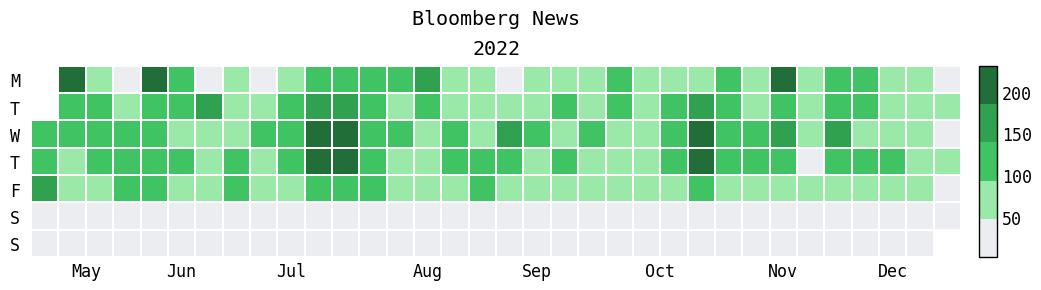

In [ ]:
import july

known_date_df = bloomberg_df[
    (bloomberg_df["date_status"] == "actual")
]

grouped22 = known_date_df[(known_date_df["date"].dt.year == 2022)].groupby(['date']).agg(count=('headline', 'count'))
calendar_df = grouped22.copy().reset_index()

july.heatmap(
    calendar_df["date"], calendar_df["count"], cmap="github", colorbar=True, title="Bloomberg News"
)

array([[<Axes: title={'center': 'May'}>,
        <Axes: title={'center': 'June'}>,
        <Axes: title={'center': 'July'}>,
        <Axes: title={'center': 'August'}>],
       [<Axes: title={'center': 'September'}>,
        <Axes: title={'center': 'October'}>,
        <Axes: title={'center': 'November'}>,
        <Axes: title={'center': 'December'}>]], dtype=object)

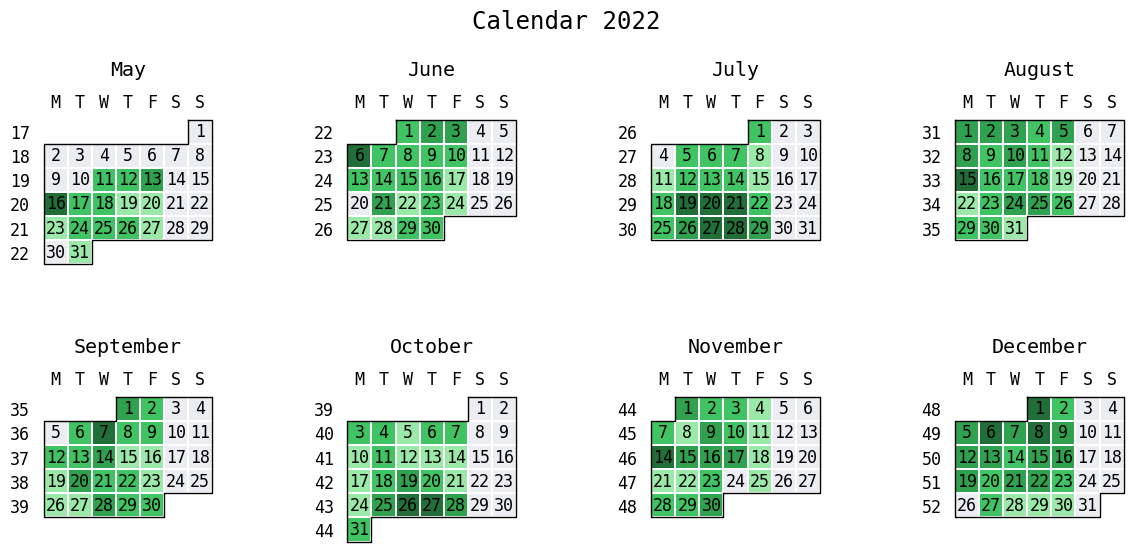

In [ ]:
import july


known_date_df = bloomberg_df[
    (bloomberg_df["date_status"] == "actual")
    # (bloomberg_df["date_status"] == "approximate")
]

grouped22 = known_date_df[(known_date_df["date"].dt.year == 2022)].groupby(['date']).agg(count=('headline', 'count'))
calendar_df = grouped22.copy().reset_index()

# Calendar plot. 
july.calendar_plot(
    calendar_df["date"], calendar_df["count"], date_label=True, cmap="github"
)

## 👌 Handling "unknown day" issue

In [ ]:
import calendar
from math import ceil


def get_avg_monthly_headlines(val) -> int:
  num_days = calendar.monthrange(2022, int(val["month"]))[1]
  return ceil(int(val["count"]) / num_days)


known_date_df = full_df_known_ticker_en_dedup[
    (full_df_known_ticker_en_dedup["date_status"] == "actual") & 
    (full_df_known_ticker_en_dedup["date"].dt.year == 2022)
]

known_date_df["month"] = known_date_df["date"].dt.month
actual_grouped_df = known_date_df.groupby(['month', "ticker"]).agg(count=('headline', 'count'))
actual_grouped_df.reset_index(inplace=True)
actual_grouped_df["avg_headings_count"] = actual_grouped_df.apply(get_avg_monthly_headlines, axis=1)

actual_grouped_dict = actual_grouped_df.to_dict(orient='records')
month_numbers = [str(m) for m in range(5,13)]

avg_count_known_headings_map = {
  'AAPL US': dict(), "AMD US":   dict(),
  "AMZN US": dict(), "GOOGL US": dict(),
  "META US": dict(), "MSFT US":  dict(),
  "NFLX US": dict(), "NVDA US":  dict(),
  "SNOW US": dict(), "TSLA US":  dict(),
}

for xx in actual_grouped_dict:
  avg_count_known_headings_map[xx["ticker"]][xx["month"]] = xx["avg_headings_count"]

# Access map like avg_count_known_headings_map[TICKER][MONTH] and you'll get avg headings per day!

In [ ]:
import plotly.express as px

calendar_df = actual_grouped_df.copy()
calendar_df.drop(columns=['count'], inplace=True)

fig = px.bar(calendar_df, x="month", y="avg_headings_count", color="ticker", title="Average count of news per ticker / month (known date)", text_auto=True)
fig.show()

In [ ]:
from random import choice


NYSE_WAS_CLOSED_DAYS = [datetime(year=2022, month=1, day=17), datetime(year=2022, month=2, day=21), datetime(year=2022, month=4, day=15)]


def get_random_business_day_for_month(val) -> datetime:
  if val["date_status"] == "actual":
    return val["date"]
  else:
    month = val["date"].month
    
    if month == 5: # special conditions for May cause we got precise date till 11-th and don't have them onwards
      month_days = [
        datetime(year=2022, month=month, day=d)
        for d in range(1, 11)                    # days of month
        if calendar.weekday(2022, month, d) < 5  # that are not a weekend
    ]
    else:
      month_days = [
        datetime(year=2022, month=month, day=d)
        for d in range(1,calendar.monthrange(2022, month)[1]+1) # days of month
        if calendar.weekday(2022, month, d) < 5                 # that are not a weekend
        and datetime(year=2022, month=month, day=d) not in NYSE_WAS_CLOSED_DAYS
    ]

    res = choice(month_days)
    return res

full_df_known_ticker_en_dedup["date"] = full_df_known_ticker_en_dedup.apply(get_random_business_day_for_month, axis=1)

full_df_known_ticker_en_dedup.head(10)


,headline,ticker,date,date_status
0,JPMorgan Mid Cap Growth Adds Tradeweb Class A ...,AMD US,2022-05-10,approximate
1,"JPMorgan Growth Advantage Exits Roku Class A ,...",TSLA US,2022-05-05,approximate
2,"JPMorgan US Equity Adds Baker Hughes Class A ,...",AMZN US,2022-05-02,approximate
3,*AMAZON.COM REMOVED FROM WEDBUSH'S BEST IDEAS ...,AMZN US,2022-05-02,approximate
4,Amazon Removed From Wedbush Best Ideas List Af...,AMZN US,2022-05-06,approximate
5,"Amazon Cloud Unit Scalability ,Momentum Push M...",AMZN US,2022-05-02,approximate
7,Apple PT Cut to $168from $184at Rosenblatt Sec...,AAPL US,2022-05-02,approximate
8,Masimo's ITC Patent Play Could Stop Apple's U....,AAPL US,2022-05-03,approximate
9,Apple Target Cut at Rosenblatt on Risks From C...,AAPL US,2022-05-03,approximate
10,Apple Hit With EU Antitrust Complaint Over IPh...,AAPL US,2022-05-05,approximate


array([[<Axes: title={'center': 'January'}>,
        <Axes: title={'center': 'February'}>,
        <Axes: title={'center': 'March'}>,
        <Axes: title={'center': 'April'}>],
       [<Axes: title={'center': 'May'}>,
        <Axes: title={'center': 'June'}>,
        <Axes: title={'center': 'July'}>,
        <Axes: title={'center': 'August'}>],
       [<Axes: title={'center': 'September'}>,
        <Axes: title={'center': 'October'}>,
        <Axes: title={'center': 'November'}>,
        <Axes: title={'center': 'December'}>]], dtype=object)

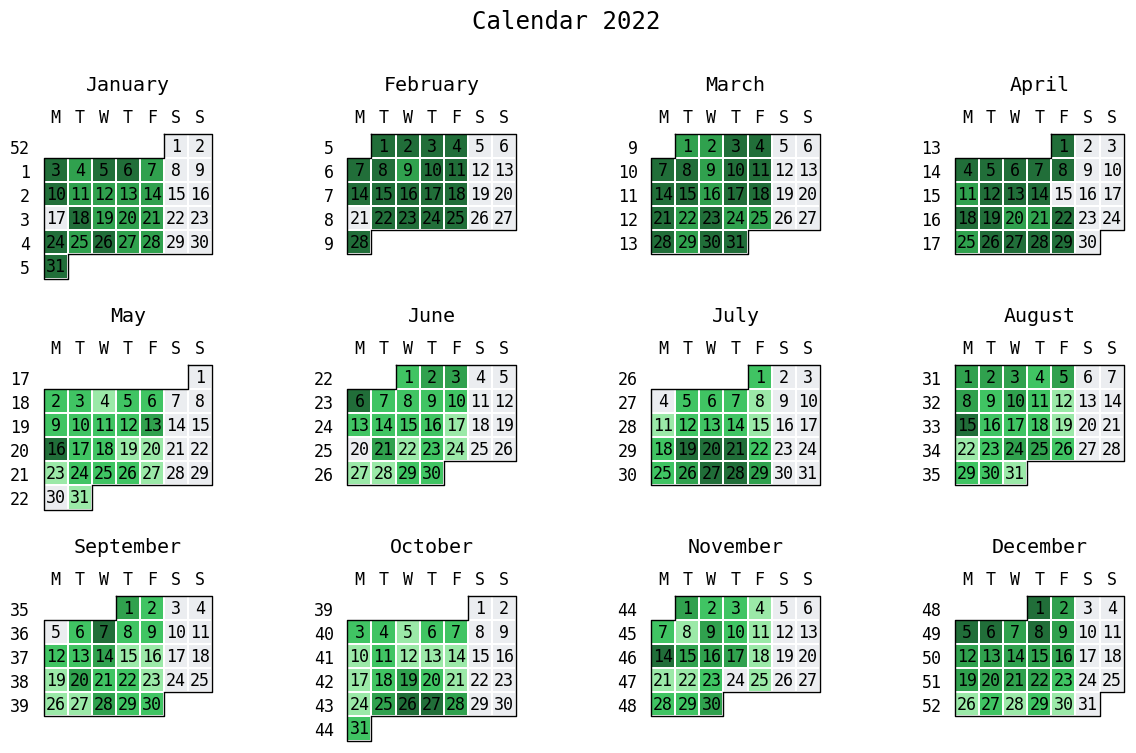

In [ ]:
import july


grouped22 = full_df_known_ticker_en_dedup[(full_df_known_ticker_en_dedup["date"].dt.year == 2022)].groupby(['date']).agg(count=('headline', 'count'))
calendar_df = grouped22.copy().reset_index()

# Calendar plot. 
july.calendar_plot(
    calendar_df["date"], calendar_df["count"], date_label=True, cmap="github"
)

In [ ]:
full_df_known_ticker_en_dedup.drop(columns=['date_status'], inplace=True)
full_df_known_ticker_en_dedup.head()

,headline,ticker,date
0,JPMorgan Mid Cap Growth Adds Tradeweb Class A ...,AMD US,2022-05-10
1,"JPMorgan Growth Advantage Exits Roku Class A ,...",TSLA US,2022-05-05
2,"JPMorgan US Equity Adds Baker Hughes Class A ,...",AMZN US,2022-05-02
3,*AMAZON.COM REMOVED FROM WEDBUSH'S BEST IDEAS ...,AMZN US,2022-05-02
4,Amazon Removed From Wedbush Best Ideas List Af...,AMZN US,2022-05-06


<Axes: title={'center': 'Bloomberg News'}>

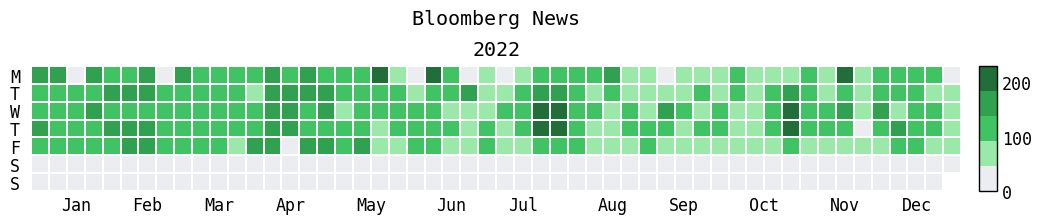

In [ ]:
import july


grouped22 = full_df_known_ticker_en_dedup[(full_df_known_ticker_en_dedup["date"].dt.year == 2022)].groupby(['date']).agg(count=('headline', 'count'))
calendar_df = grouped22.copy().reset_index()

july.heatmap(
    calendar_df["date"], calendar_df["count"], cmap="github", colorbar=True, title="Bloomberg News"
)

In [ ]:
full_df_known_ticker_en_dedup = full_df_known_ticker_en_dedup.sort_values(by=['date'])

full_df_known_ticker_en_dedup.head(5)

,headline,ticker,date
4064,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03
6939,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03
14632,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03
19017,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03
24184,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03


In [ ]:
# full_df_known_ticker_en_dedup.to_csv('/content/sample_data/bloomberg_news_and_tickers_2022_V2.csv', index=False)

# 👾 Stocks


In [ ]:
!pip install july

In [ ]:
from datetime import datetime

def normalize_date(s: str) -> datetime:
  month, day, year = s.split("/")
  m = int(month, 10)
  d = int(day, 10)

  if year.startswith("20"):
    y = int(year, 10)
  else:
    y = int("20" + year, 10)

  return datetime(year=y, month=m, day=d)


def normalize_number(val: str) -> int:
  if val and pd.notnull(val) and not val.isspace():
    return int(val.replace(",", "").split(".")[0])
  else:
    return None


stocks_df = pd.read_csv(os.path.join(ROOT_BLOOMBERG_DATA_FOLDER, "nysefaangplus_bloomberg.csv"), sep=";")
stocks_df = stocks_df[["Date", "Open Px", "Last Price"]]
stocks_df = stocks_df.rename(columns={'Date': 'NF_date', 'Open Px': 'NF_open', "Last Price": "NF_close"})
stocks_df = stocks_df[pd.notnull(stocks_df.NF_date)]

stocks_df["NF_date"] = stocks_df["NF_date"].apply(lambda val: normalize_date(val))
stocks_df["NF_open"] = stocks_df["NF_open"].apply(lambda val: normalize_number(val))
stocks_df["NF_close"] = stocks_df["NF_close"].apply(lambda val: normalize_number(val))

stocks_df = stocks_df.sort_values(by=['NF_date'])

display(stocks_df)

,NF_date,NF_open,NF_close
269,2021-12-27,7443.0,7539.0
268,2021-12-28,7539.0,7482.0
267,2021-12-29,7482.0,7421.0
266,2021-12-30,7421.0,7524.0
265,2021-12-31,7524.0,7421.0
...,...,...,...
4,2023-01-02,NaN,NaN
3,2023-01-03,4448.0,4376.0
2,2023-01-04,4376.0,4401.0
1,2023-01-05,4401.0,4293.0


<Axes: title={'center': 'NYSE FAANG+ Stocks data availability'}>

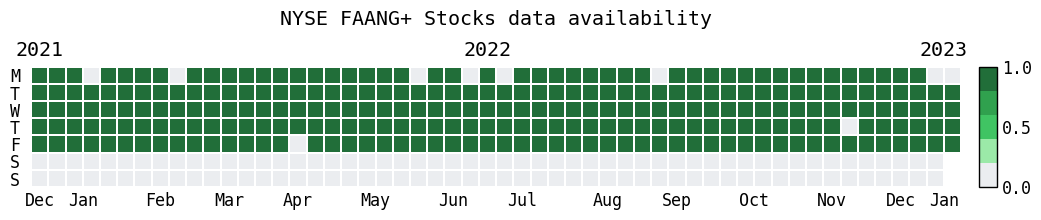

In [ ]:
import july

x = stocks_df.groupby(['NF_date']).agg(count=('NF_open', 'count'))
calendar_df = x.copy().reset_index()

july.heatmap(
    calendar_df["NF_date"], calendar_df["count"], cmap="github", colorbar=True, title="NYSE FAANG+ Stocks data availability"
)

array([[<Axes: title={'center': 'January'}>,
        <Axes: title={'center': 'February'}>,
        <Axes: title={'center': 'March'}>,
        <Axes: title={'center': 'April'}>],
       [<Axes: title={'center': 'May'}>,
        <Axes: title={'center': 'June'}>,
        <Axes: title={'center': 'July'}>,
        <Axes: title={'center': 'August'}>],
       [<Axes: title={'center': 'September'}>,
        <Axes: title={'center': 'October'}>,
        <Axes: title={'center': 'November'}>,
        <Axes: title={'center': 'December'}>]], dtype=object)

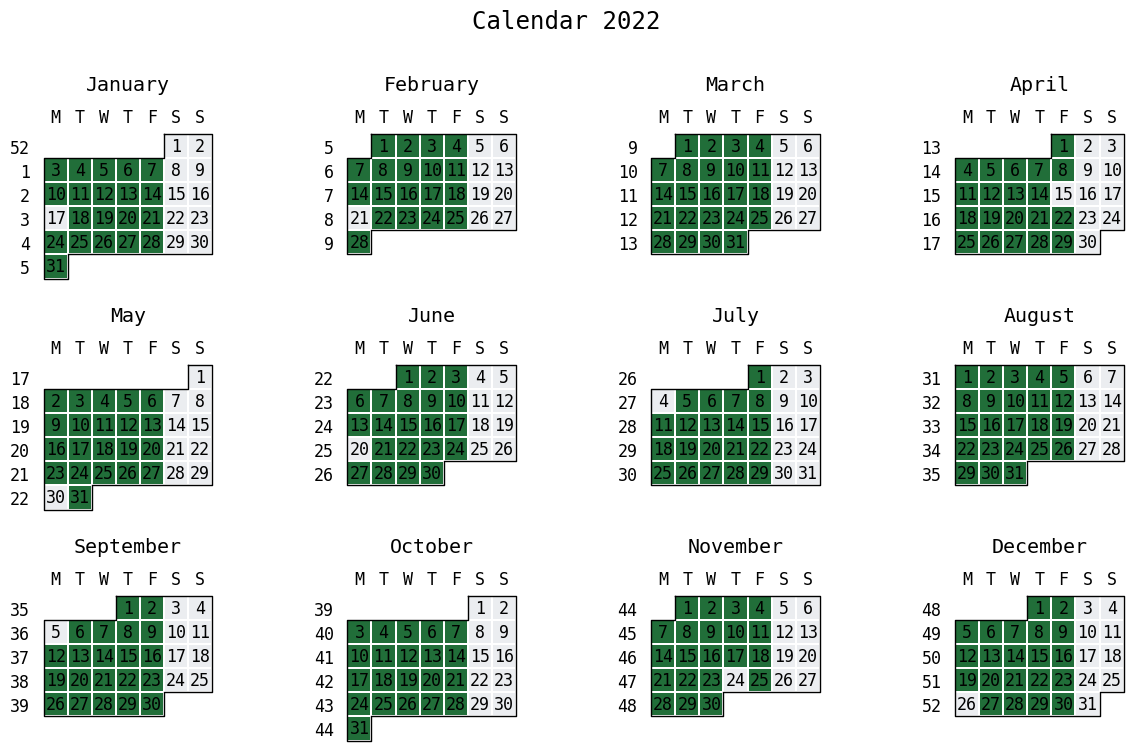

In [ ]:
import july


x = stocks_df[stocks_df['NF_date'].dt.year == 2022].groupby(['NF_date']).agg(count=('NF_open', 'count'))
calendar_df = x.copy().reset_index()

# Calendar plot. 
july.calendar_plot(
    calendar_df["NF_date"], calendar_df["count"], date_label=True, cmap="github"
)

In [ ]:
stocks_df.head()

,NF_date,NF_open,NF_close
269,2021-12-27,7443.0,7539.0
268,2021-12-28,7539.0,7482.0
267,2021-12-29,7482.0,7421.0
266,2021-12-30,7421.0,7524.0
265,2021-12-31,7524.0,7421.0


In [ ]:
# stocks_df.to_csv('/content/sample_data/bloomberg_nyse_faang_original.csv', index=False)

In [ ]:
import plotly.express as px

df = stocks_df.copy()
df = df[df["NF_date"].dt.year == 2022]
fig = px.line(df, x='NF_date', y="NF_close")
fig.show()

# 👾 Merging

In [ ]:
S_df = pd.read_csv("/content/sample_data/bloomberg_nyse_faang_original.csv")
N_df = pd.read_csv("/content/sample_data/bloomberg_news_and_tickers_2022_V2.csv")

In [ ]:
S_df.sample(10)

,NF_date,NF_open,NF_close
267,2023-01-04,4376.0,4401.0
266,2023-01-03,4448.0,4376.0
79,2022-04-15,NaN,NaN
22,2022-01-26,6460.0,6376.0
244,2022-12-02,4917.0,4961.0
90,2022-05-02,5348.0,5511.0
53,2022-03-10,6038.0,5912.0
159,2022-08-05,5683.0,5566.0
187,2022-09-14,5070.0,5111.0
269,2023-01-06,4293.0,4401.0


In [ ]:
N_df.sample(10)

,headline,ticker,date
8387,Apollo Global Could Back Musk's Twitter Bid or...,TSLA US,2022-04-08
15802,Wall Street's Simpson Thacher Widens Lead as T...,MSFT US,2022-07-11
28056,Twitter Users Deliver Verdict Musk Probably Wa...,TSLA US,2022-12-19
23242,*TESLA :REMAIN FOCUSED ON BOOSTING OUTPUT AS Q...,TSLA US,2022-10-19
15476,"Dreyfus Large Cap Equity Adds Broadcom ,Exits ...",AAPL US,2022-07-05
11792,AllianzGI Focused Growth Exits Align Technolog...,NVDA US,2022-05-16
17977,Semiconductor Sales Data Show Memory Weakness ...,NVDA US,2022-08-01
13655,Twitter Plans to Comply With Musk Data Demands...,TSLA US,2022-06-08
831,Elon Musk's Fortune Climbs $34Billion on Tesla...,TSLA US,2022-01-10
26560,Won't China Protests Hit Supply Chains Too Har...,AAPL US,2022-11-30


In [ ]:
result = pd.merge(
    N_df,
    S_df,
    how='inner',
    left_on='date', 
    right_on='NF_date'
)

result.drop(columns=['NF_date'], inplace=True)

result.head(15)

,headline,ticker,date,NF_open,NF_close
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,7421.0,7591.0
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,7421.0,7591.0
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,7421.0,7591.0
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,7421.0,7591.0
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,7421.0,7591.0
5,ESG Top Themes in U.S. for Jan. 28,TSLA US,2022-01-03,7421.0,7591.0
6,"Daimler ,GM Lead Carbon Transition for Non -El...",TSLA US,2022-01-03,7421.0,7591.0
7,"Facebook ,Google Digital -Ad Sales Can Bear FT...",AMZN US,2022-01-03,7421.0,7591.0
8,Materials Stocks Drive Earnings Misses for S &...,AAPL US,2022-01-03,7421.0,7591.0
9,Google Acquiring Cyber Startup Siemplify for $...,GOOGL US,2022-01-03,7421.0,7591.0
